In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import numpy as np
from tqdm import tqdm
from collections import defaultdict

import matplotlib.pyplot as plt

import sys; sys.path.append('../PGDL/sample_code_submission/')
from internal_rep.matrix_funcs import \
    get_KF_Schatten_norms, \
    compute_complexity, \
    get_df_tau, \
    evalues_from_regions, \
    get_local_rad_bound


# This notebook niche
import keras.backend as K
import heapq

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [12]:
n_train_sample = 1000

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# Train pipeline
ds_train = ds_train.take(n_train_sample)
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

# Test pipeline
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
# Source https://github.com/lilianweng/generalization-experiment/blob/master/utils.py
def dense_nn(inputs, layers_sizes, name="fc", reuse=False, output_fn=None,
             dropout_keep_prob=None, training=True):
    logging.info(f"Building mlp {name} | sizes: {[inputs.shape[0]] + layers_sizes}")
    with tf.variable_scope(name, reuse=reuse):
        out = inputs
        for i, size in enumerate(layers_sizes):
            if i > 0 and dropout_keep_prob is not None and training:
                # No dropout on the input layer.
                out = tf.nn.dropout(out, keep_prob=dropout_keep_prob)

            out = tf.layers.dense(
                out,
                size,
                kernel_initializer=tf.contrib.layers.xavier_initializer(),
                bias_initializer=tf.constant_initializer(0.0),
                name=name + '_l' + str(i),
                reuse=reuse,
                # Add relu activation only for internal layers.
                activation=tf.nn.relu if i < len(layers_sizes) - 1 else None,
            )

        if output_fn:
            out = output_fn(out)

    return out

In [23]:
def fit_model(model, n_epochs, optimizer, loss_fn, metric, metric_dict={}):
    @tf.function
    def _train_step(x, y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            loss_value = loss_fn(y, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric
        metric.update_state(y, logits)
        return loss_value

    # @tf.function
    def _test_step(x, y):
        logits = model(x, training=False)
        # Update val metrics
        metric.update_state(y, logits)
        return logits, y

    model_results = defaultdict(list)
    
    for epoch in range(n_epochs):
        losses = []
        for step, (x_batch, y_batch) in enumerate(ds_train):
            loss_value = _train_step(x_batch, y_batch)
            losses.append(loss_value)
        model_results['train_loss'].append(np.mean(losses))
            
        # Display metrics at the end of each epoch.
        train_acc = metric.result()
        metric.reset_states()
        
        model_results['train_accuracy'].append(train_acc)
        
        # Run a validation loop at the end of each epoch.
        logit_list = []
        y_list = []
        for x_batch, y_batch in ds_test:
            logits, y = _test_step(x_batch, y_batch)
            logit_list.append(logits)
            y_list.append(y)
        y_list = tf.concat(y_list, axis=0)
        logit_list = tf.concat(logit_list, axis=0)
        model_results['test_ece'].append(tfp.stats.expected_calibration_error(10, logit_list, y_list))
              
        test_acc = metric.result()
        metric.reset_states()
        model_results['test_accuracy'].append(test_acc)
        
        # Get the complexity at the end of each epoch
        # Add model complexity
        internal_rep = []
        for x_batch, y_batch in ds_train:
            for layer in model.layers[:-1]:
                x_batch = layer(x_batch)
            internal_rep.append((x_batch.numpy() > 0).astype('bool'))
        internal_rep = np.vstack(internal_rep)
        active_relus = model.layers[-2].connections.numpy().sum(0)
        active_relu_indices = np.where(active_relus == 1)[0]
        evalues = evalues_from_regions(internal_rep[:, active_relu_indices])
        h_star, h_argmin = get_local_rad_bound(evalues, from_evalues=True)
        model_results['h*'].append(h_star)
        model_results['h_argmin'].append(h_argmin)
        model_results['n_activated_regions'].append(sum(evalues > 0))
        
        if epoch % 5 == 0 or epoch == n_epochs-1:
            print(f"Epoch {epoch}: Training acc={train_acc:.3f}, Validation acc={test_acc:.3f}")
    
    n_train_samples = internal_rep.shape[0]
    # relu_sep = (np.abs(internal_rep.sum(0) - n_train_samples / 2) + n_train_samples / 2) / n_train_samples
    relu_sep = (internal_rep.sum(0) - n_train_samples / 2) / n_train_samples # need the sign too. + <=> relu>0
    
    model_results['separation_frac'] = relu_sep
    model_results['internal_rep'] = internal_rep
    
    return model, model_results

def eval_model(model, metric, dataset):

    # @tf.function
    def _test_step(x, y):
        logits = model(x, training=False)
        # Update val metrics
        metric.update_state(y, logits)
        return logits, y

    model_results = {}
    # Run a validation loop at the end of each epoch.
    logit_list = []
    y_list = []
    for x_batch, y_batch in dataset:
        logits, y = _test_step(x_batch, y_batch)
        logit_list.append(logits)
        y_list.append(y)
    y_list = tf.concat(y_list, axis=0)
    logit_list = tf.concat(logit_list, axis=0)
    model_results['ece'] = tfp.stats.expected_calibration_error(10, logit_list, y_list)

    test_acc = metric.result()
    metric.reset_states()
    model_results['accuracy'] = test_acc
    
    return model_results

In [15]:
# To remove relu by deleting output
class CustomConnected(tf.keras.layers.Dense):
    def __init__(self, units, connections=None, activations=None, **kwargs):

        #this is matrix A
        self.connections = connections  
        if activations is not None and type(activations) is not list:
            if type(activations) == str:
                self.activations = [tf.keras.activations.get(activations)] * units
            else:
                self.activations = [activations] * units
        else:
            self.activations = activations

        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activations is not None:
            slices = tf.unstack(output, axis=1)
            activated = []
            for s, act in zip(slices, self.activations):
                activated.append(act(s))
            output = tf.stack(activated, axis=1)
        elif self.activation is not None:
            output = self.activation(output)
        
        if self.connections is not None:
            output = tf.matmul(output, self.connections)
        
        return output

## Prune w/ retraining

In [68]:
# Across pruning
results_dict = {}

n_units = 100
total_params = (28 * 28 + 1) * n_units + (n_units + 1) * 10

prune_mat = tf.eye(n_units)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  CustomConnected(n_units, prune_mat ), #activations='relu')# tf.keras.layers.Dense(n_units, activation='relu'),
  tf.keras.layers.Dense(10) # CustomConnected(10, prune_mat) # 
])

n_epochs = 50
optimizer = tf.keras.optimizers.Adam(0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [69]:
n_prune_per_iter = 2
for i in range((n_units // n_prune_per_iter)):
    # Train
    model, model_results = fit_model(model, n_epochs if i == 0 else 5, optimizer, loss_fn, metric)
    results_dict[np.sum(prune_mat).astype(int)] = model_results
    
    # Get prune matrix
    prune_index = np.asarray(heapq.nlargest(
        (i+1)*n_prune_per_iter,
        range(n_units),
        key=model_results['separation_frac'].__getitem__))
    prune_diag = np.copy(np.diag(prune_mat.numpy()))# .astype('float32')
    prune_diag[prune_index] = 0
    prune_mat = tf.linalg.diag(prune_diag)
    prune_mat = tf.constant(prune_mat)
    
    # Prune weights
    model.layers[2].connections = prune_mat
    # print(np.abs(model.layers[2].weights[0].numpy()[prune_index]).sum())

AttributeError: 'Dense' object has no attribute 'connections'

In [325]:
combined_dict = defaultdict(list)
for n_relus, model_results in results_dict.items():
    for metric, vals in model_results.items():
        combined_dict[metric].append(vals)
    combined_dict['n_relus'].append([n_relus] * len(model_results['train_loss']))
        
combined_dict['mean_sep_frac'] = [
    [-np.mean(np.asarray(heapq.nlargest(n_units - n_prune_per_iter*(i+1), -sf)))] * len(train_losses)
    for i, (sf, train_losses) in enumerate(zip(combined_dict['separation_frac'], combined_dict['train_loss']))
]

for key, val in combined_dict.items():
    try:
        combined_dict[key] = np.concatenate(val)
    except:
        pass
#     if key in ['train_accuracy', 'test_accuracy']:
#         combined_dict[key] = [v.numpy() for v in combined_dict[key]]

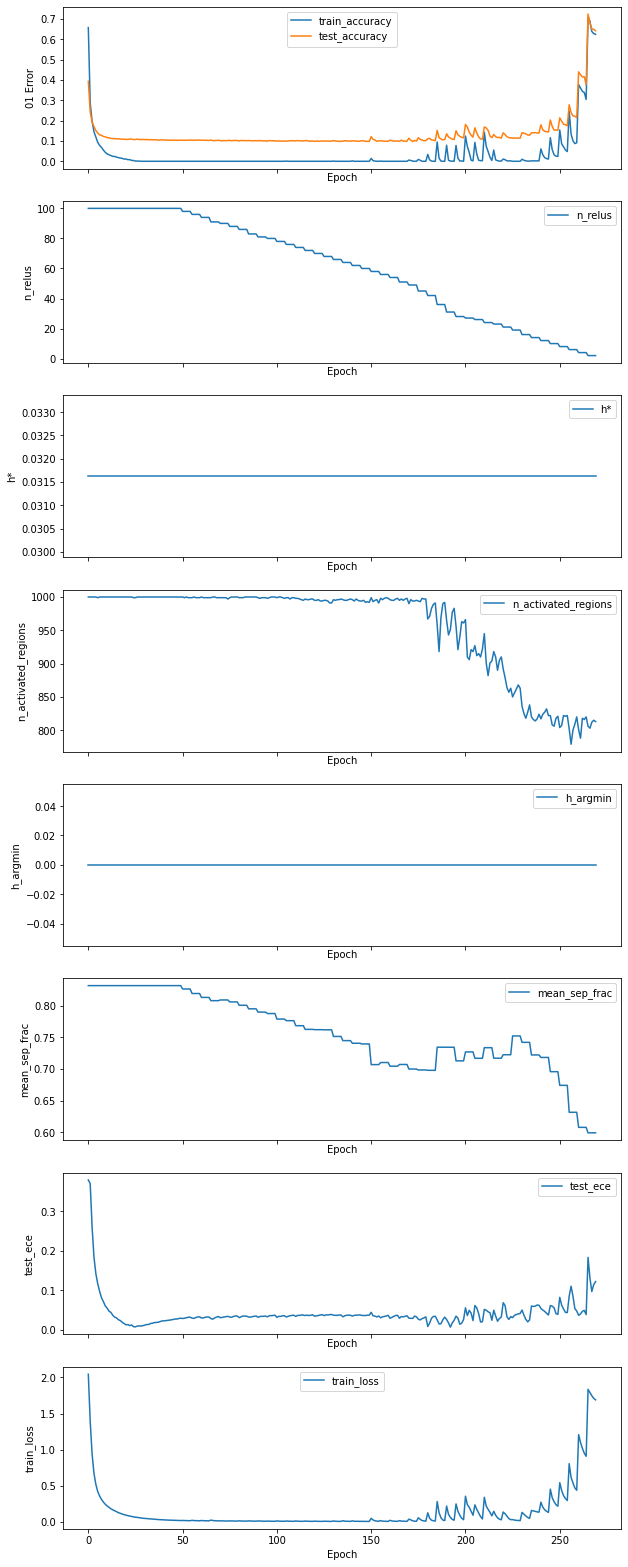

In [326]:
keys = ['n_relus', 'h*', 'n_activated_regions', 'h_argmin', 'mean_sep_frac', 'test_ece', 'train_loss']

fig, axes = plt.subplots(len(keys)+1, 1, figsize=(10, 4*len(keys)), sharex=True)

ax = axes[0]
for key in ['train_accuracy', 'test_accuracy']:
    ax.plot(np.arange(len(combined_dict[key])), 1 - np.asarray(combined_dict[key]), label=key)
ax.legend()
ax.set_ylabel('01 Error')
ax.set_xlabel('Epoch')
# ax.set_xscale('log')

for ax, key in zip(axes[1:], keys):
    ax.plot(np.arange(len(combined_dict[key])), combined_dict[key], label=key)
    ax.set_ylabel(key)
    ax.legend()
    ax.set_xlabel('Epoch')
    # ax.set_xscale('log')

plt.show()

## Prune no retraining

In [20]:
# Across pruning
results_dict = {}

n_units = 10
total_params = (28 * 28 + 1) * n_units + (n_units + 1) * 10

prune_mat = tf.eye(n_units)

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    CustomConnected(n_units, prune_mat, activations='relu'),#'relu'),# tf.keras.layers.Dense(n_units, activation='relu'),
    tf.keras.layers.Dense(n_units, activation='linear'),
])

n_epochs = 50
optimizer = tf.keras.optimizers.Adam(0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [21]:
for x_batch, y_batch in ds_train:
    for layer in model.layers[:-1]:
        x_batch = layer(x_batch)
    break

In [22]:
model, model_results = fit_model(model, n_epochs, optimizer, loss_fn, metric)

Epoch 0: Training acc=0.179, Validation acc=0.275
Epoch 5: Training acc=0.698, Validation acc=0.688
Epoch 10: Training acc=0.822, Validation acc=0.781
Epoch 15: Training acc=0.866, Validation acc=0.817
Epoch 20: Training acc=0.893, Validation acc=0.833
Epoch 25: Training acc=0.919, Validation acc=0.844
Epoch 30: Training acc=0.930, Validation acc=0.853
Epoch 35: Training acc=0.946, Validation acc=0.862


KeyboardInterrupt: 

In [249]:
results = defaultdict(list)
res = 50

for purity in np.linspace(0.5 + 0.5 / res, 0, res+2):
    results['relu_hyperplane_balance'].append(1 - purity*2)
    
    prune_delete_edge = np.where(model_results['separation_frac'] <= -purity)[0]
    prune_delete_relu = np.where(model_results['separation_frac'] >= purity)[0]
    results['n_relus'].append(n_units - len(prune_delete_edge) - len(prune_delete_relu))
    
    # Prune relus that are always off
    prune_diag = np.ones(n_units).astype('float32')
    prune_diag[prune_delete_edge] = 0
    model.layers[1].connections = tf.constant(tf.linalg.diag(prune_diag))
    
    # Prune relus that are always on
    for idx in (prune_delete_relu):
        model.layers[1].activations[idx] = eye_activation
        
    active_relu_indices = np.setdiff1d(np.arange(n_units), np.concatenate((prune_delete_relu, prune_delete_edge)))
    evalues = evalues_from_regions(model_results['internal_rep'][:, active_relu_indices])
    results['n_activated_regions'].append(sum(evalues > 0))
        
    test_results = eval_model(model, metric, ds_test)
    for key, val in test_results.items():
        results['test_' + key].append(val)
        
    train_results = eval_model(model, metric, ds_train)
    for key, val in train_results.items():
        results['train_' + key].append(val)

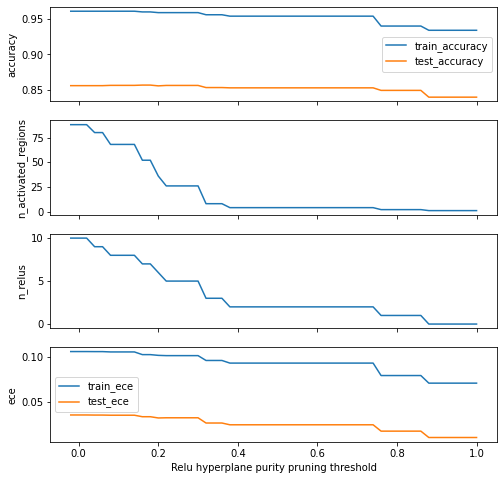

In [250]:
panel_keys =  ['accuracy', 'n_activated_regions', 'n_relus', 'ece']
fig, axes = plt.subplots(len(panel_keys), 1, figsize=(8, 2*(len(panel_keys))), sharex=True)
for ax, key in zip(axes, panel_keys):
    if key in ['accuracy', 'ece']:
        for k in ['train_' + key, 'test_' + key]:
            ax.plot(results['relu_hyperplane_balance'], results[k], label=k)
        ax.legend()
    else:
        ax.plot(results['relu_hyperplane_balance'], results[key], label=key)
    
    ax.set_ylabel(key)
axes[-1].set_xlabel('Relu hyperplane purity pruning threshold')
plt.show()

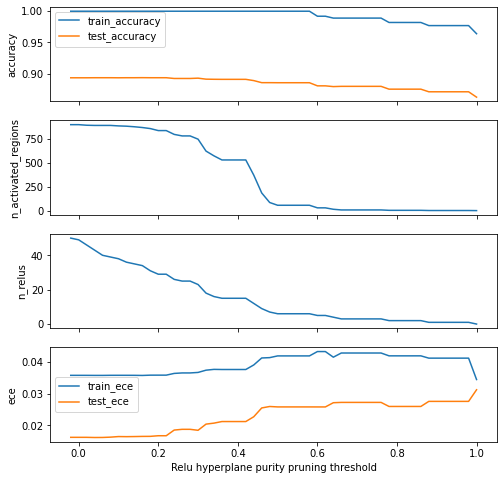

In [239]:
panel_keys =  ['accuracy', 'n_activated_regions', 'n_relus', 'ece']
fig, axes = plt.subplots(len(panel_keys), 1, figsize=(8, 2*(len(panel_keys))), sharex=True)
for ax, key in zip(axes, panel_keys):
    if key in ['accuracy', 'ece']:
        for k in ['train_' + key, 'test_' + key]:
            ax.plot(results['relu_hyperplane_balance'], results[k], label=k)
        ax.legend()
    else:
        ax.plot(results['relu_hyperplane_balance'], results[key], label=key)
    
    ax.set_ylabel(key)
axes[-1].set_xlabel('Relu hyperplane purity pruning threshold')
plt.suptitle('Relu-net o MNIST', y=0.92)
plt.show()

In [16]:
prune_index = np.asarray(heapq.nlargest(
    n_units,
    range(n_units),
    key=np.abs(model_results['separation_frac']).__getitem__))

In [18]:
model_results['separation_frac'][prune_index]

array([-0.5  , -0.499,  0.494,  0.486,  0.484,  0.483,  0.474,  0.474,
        0.472,  0.469,  0.467,  0.467,  0.465,  0.464,  0.464,  0.456,
        0.456,  0.456,  0.455,  0.454,  0.452,  0.451,  0.449,  0.447,
        0.442,  0.44 ,  0.435,  0.432,  0.429,  0.424,  0.422,  0.422,
        0.416,  0.409,  0.408,  0.408,  0.406,  0.404,  0.401,  0.398,
        0.397,  0.393,  0.386,  0.386,  0.385,  0.383,  0.381,  0.372,
        0.368,  0.362,  0.348, -0.343,  0.342,  0.342,  0.342,  0.334,
        0.33 ,  0.327,  0.326,  0.324,  0.323,  0.323,  0.318,  0.314,
        0.306,  0.3  ,  0.296,  0.292, -0.284,  0.272,  0.27 ,  0.269,
        0.264,  0.262,  0.259, -0.256, -0.255,  0.247,  0.245,  0.24 ,
        0.21 ,  0.202,  0.185,  0.172,  0.165,  0.149,  0.126, -0.12 ,
        0.118, -0.115,  0.105, -0.091,  0.087, -0.08 , -0.076,  0.064,
        0.048,  0.035, -0.019, -0.01 ])

In [22]:
eval_model(model, metric)

{'test_ece': <tf.Tensor: shape=(), dtype=float32, numpy=0.02791968>,
 'test_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.8989>}

In [ ]:
n_prune_per_iter = 2
for i in range((n_units // n_prune_per_iter)):
    # Train
    model, model_results = fit_model(model, n_epochs if i == 0 else 5, optimizer, loss_fn, metric)
    results_dict[np.sum(prune_mat).astype(int)] = model_results
    
    # Get prune matrix
    prune_index = np.asarray(heapq.nlargest(
        (i+1)*n_prune_per_iter,
        range(n_units),
        key=model_results['separation_frac'].__getitem__))
    prune_diag = np.copy(np.diag(prune_mat.numpy()))# .astype('float32')
    prune_diag[prune_index] = 0
    prune_mat = tf.linalg.diag(prune_diag)
    prune_mat = tf.constant(prune_mat)
    
    # Prune weights
    model.layers[2].connections = prune_mat
    # print(np.abs(model.layers[2].weights[0].numpy()[prune_index]).sum())

## Cifar pruning no retraining

In [181]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    data_dir='/mnt/ssd3/ronan/tensorflow_datasets/',
)

In [182]:
n_train_sample = 10000
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# Train pipeline
ds_train = ds_train.take(n_train_sample)
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

# Test pipeline
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [183]:
# Across pruning
results_dict = {}

n_units = 100

prune_mat = tf.eye(n_units)

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    CustomConnected(n_units, prune_mat, activations='relu'),# tf.keras.layers.Dense(n_units, activation='relu'),
    tf.keras.layers.Dense(10) # CustomConnected(10, prune_mat) # 
])

n_epochs = 70
optimizer = tf.keras.optimizers.Adam(0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [184]:
model, model_results = fit_model(model, n_epochs, optimizer, loss_fn, metric)

Epoch 0: Training acc=0.222, Validation acc=0.293
Epoch 5: Training acc=0.352, Validation acc=0.361
Epoch 10: Training acc=0.381, Validation acc=0.366
Epoch 15: Training acc=0.414, Validation acc=0.373
Epoch 20: Training acc=0.420, Validation acc=0.378
Epoch 25: Training acc=0.442, Validation acc=0.376
Epoch 30: Training acc=0.449, Validation acc=0.395
Epoch 35: Training acc=0.462, Validation acc=0.402
Epoch 40: Training acc=0.472, Validation acc=0.405
Epoch 45: Training acc=0.475, Validation acc=0.393
Epoch 50: Training acc=0.486, Validation acc=0.412
Epoch 55: Training acc=0.501, Validation acc=0.403
Epoch 60: Training acc=0.498, Validation acc=0.411
Epoch 65: Training acc=0.508, Validation acc=0.406
Epoch 69: Training acc=0.513, Validation acc=0.402


In [185]:
results = defaultdict(list)
res = 50

for purity in np.linspace(0.5 + 0.5 / res, 0, res+2):
    results['Impurity'].append(1 - purity*2)
    
    prune_delete_edge = np.where(model_results['separation_frac'] <= -purity)[0]
    prune_delete_relu = np.where(model_results['separation_frac'] >= purity)[0]
    results['n_relus'].append(n_units - len(prune_delete_edge) - len(prune_delete_relu))
    
    # Prune relus that are always off
    prune_diag = np.ones(n_units).astype('float32')
    prune_diag[prune_delete_edge] = 0
    model.layers[1].connections = tf.constant(tf.linalg.diag(prune_diag))
    
    # Prune relus that are always on
    for idx in (prune_delete_relu):
        model.layers[1].activations[idx] = eye_activation
        
    active_relu_indices = np.setdiff1d(np.arange(n_units), np.concatenate((prune_delete_relu, prune_delete_edge)))
    evalues = evalues_from_regions(model_results['internal_rep'][:, active_relu_indices])
    results['n_activated_regions'].append(sum(evalues > 0))
        
    eval_dict = eval_model(model, metric)
    for key, val in eval_dict.items():
        results[key].append(val)

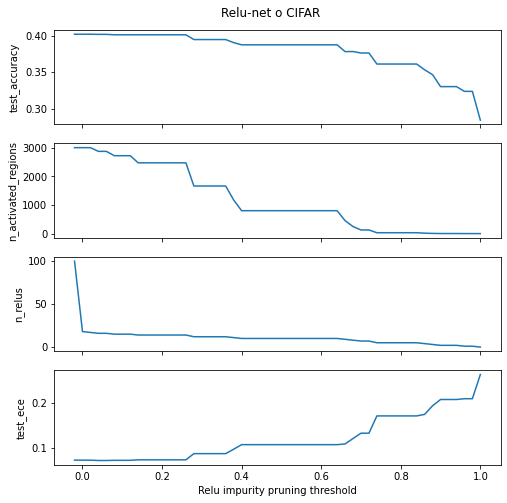

In [191]:
panel_keys =  ['test_accuracy', 'n_activated_regions', 'n_relus', 'test_ece']
fig, axes = plt.subplots(len(panel_keys), 1, figsize=(8, 2*(len(panel_keys))), sharex=True)
for ax, key in zip(axes, panel_keys):
    ax.plot(results['Impurity'], results[key])
    ax.set_ylabel(key)
    
axes[-1].set_xlabel('Relu impurity pruning threshold')
plt.suptitle('Relu-net o CIFAR', y=0.92)
plt.show()